## In this notebook we will modeling play by play yac data


In [1]:
#Read in data/ install packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#Lets first get all of our data into pandas dataframes
games = pd.read_csv('data/games.csv')
players = pd.read_csv('data/players.csv')
plays = pd.read_csv('data/plays.csv')
tackles = pd.read_csv('data/tackles.csv')
# Assuming your tracking data files are named tracking_week_1.csv, tracking_week_2.csv, ..., tracking_week_9.csv
data_dir = Path("data/")  # Update with the correct path
tracking_dfs = sorted(data_dir.glob("tracking_week_*.csv"))

# Create an empty list to store individual week dataframes
week_dfs = []

# Iterate through each tracking data file and load it into a dataframe
for week_number, tracking_file in enumerate(tracking_dfs, start=1):
    week_df = pd.read_csv(tracking_file)
    
    # Add a 'week' column with the corresponding week number
    week_df['week'] = week_number
    
    # Append the dataframe to the list
    week_dfs.append(week_df)

# Combine all week dataframes into a single dataframe
tracking = pd.concat(week_dfs, ignore_index=True)


In [4]:
tracking.event.unique()

array([nan, 'pass_arrived', 'pass_outcome_caught', 'tackle', 'run',
       'first_contact', 'ball_snap', 'handoff', 'touchdown',
       'out_of_bounds', 'man_in_motion', 'fumble', 'play_action',
       'pass_forward', 'lateral', 'autoevent_passforward',
       'autoevent_passinterrupted', 'line_set', 'qb_slide', 'shift',
       'run_pass_option', 'qb_sack', 'pass_shovel', 'autoevent_ballsnap',
       'snap_direct', 'fumble_defense_recovered',
       'fumble_offense_recovered', 'penalty_flag', 'safety',
       'pass_outcome_touchdown', 'penalty_accepted'], dtype=object)

In [5]:
#Filter out any non-pass plays
yac_df = plays[['gameId','playId','ballCarrierId','ballCarrierDisplayName','yardsToGo','possessionTeam','defensiveTeam','yardlineSide','yardlineNumber']]
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41
1,2022091103,3126,52457,Chase Claypool,10,PIT,CIN,PIT,34
2,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30
3,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,37
4,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,35
...,...,...,...,...,...,...,...,...,...
12481,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,39
12482,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,30
12483,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,41
12484,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,34


In [6]:
# Get plays with 'first_contact' event
plays_with_first_contact = tracking[tracking['event'] == 'first_contact'][['gameId', 'playId']].drop_duplicates()

# Get plays with the specified events
relevant_events = ['pass_outcome_caught', 'run', 'handoff']
plays_with_other_events = tracking[tracking['event'].isin(relevant_events)][['gameId', 'playId']].drop_duplicates()

# Filter yac_df for plays that satisfy both conditions
filtered_plays = plays_with_first_contact.merge(plays_with_other_events, on=['gameId', 'playId'], how='inner')
yac_df = yac_df[yac_df.set_index(['gameId', 'playId']).index.isin(filtered_plays.set_index(['gameId', 'playId']).index)]


## Calculate yards gained after the 'first_contact' frame

In [7]:
def yards_after_contact(row, tracking):
    gameId = row['gameId']
    playId = row['playId']
    ballCarrierId = row['ballCarrierId']
    
    selected_tracking = tracking[(tracking.gameId == gameId) & (tracking.playId == playId) & (tracking.nflId == ballCarrierId)]

    # Check if there are matching rows
    if not selected_tracking.empty:
        first_contact_row = selected_tracking.loc[selected_tracking.event == 'first_contact', 'x']
        tackle_row = selected_tracking.loc[selected_tracking.event == 'tackle', 'x']

        # Check if rows with 'first_contact' and 'tackle' events exist
        if not first_contact_row.empty and not tackle_row.empty:
            x_first_contact = first_contact_row.values[0]
            x_tackle = tackle_row.values[0]

            play_direction = selected_tracking['playDirection'].values[0]

            if play_direction == 'right':
                yards_gained = x_tackle - x_first_contact
            else:
                yards_gained = x_first_contact - x_tackle

            # Forward progress rule
            yards_gained = max(0, yards_gained)
        else:
            # If events are not found, set yards_gained to 0
            yards_gained = 0
    else:
        # If no matching rows are found, set yards_gained to 0
        yards_gained = 0

    return yards_gained


In [8]:
yac_df['yards_after_contact'] = yac_df.apply(yards_after_contact, args=(tracking,), axis=1)
yac_df

C:\Users\cquin\AppData\Local\Temp\ipykernel_2400\2108386957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yac_df['yards_after_contact'] = yac_df.apply(yards_after_contact, args=(tracking,), axis=1)


,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,yards_after_contact
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41,0.30
2,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30,1.52
3,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,37,4.74
4,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,35,2.97
5,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18,1.12
...,...,...,...,...,...,...,...,...,...,...
12481,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,39,2.26
12482,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,30,1.25
12483,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,41,3.77
12484,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,34,0.00


## Which defender made first contact?
I will determine this by calculating the euclidean distance between all defenders and the ballcarrier at the frame of first contact. I will then drop any plays in which the labelled "first defender" is not accredited with a tackle in the tackles dataframe

In [9]:
tracking_fc = pd.merge(tracking, plays[['gameId','playId', 'ballCarrierId', 'defensiveTeam']], on = ['gameId','playId'], how='left')


# Drop rows with NaN values in the 'nflId' column
tracking_fc.dropna(subset=['nflId'], inplace=True)

tracking_fc['nflId'] = pd.to_numeric(tracking_fc['nflId'], errors='coerce').astype(int)

tracking_fc = tracking_fc[(tracking_fc.nflId == tracking_fc.ballCarrierId) | (tracking_fc.club == tracking_fc.defensiveTeam)]
tracking_fc = tracking_fc[
    tracking_fc.set_index(['gameId', 'playId']).index.isin(yac_df.set_index(['gameId', 'playId']).index)
]

tracking_fc = pd.merge(tracking_fc, yac_df[['gameId','playId','ballCarrierDisplayName','yardsToGo','yards_after_contact']], on = ['gameId','playId'], how='left')

In [10]:
# Merge DataFrames based on gameId, playId, and nflId
tracking_fc = pd.merge(tracking_fc, tackles[['gameId', 'playId', 'nflId']], 
                     on=['gameId', 'playId', 'nflId'], how='left', indicator=True)

# Add a new column 'involved_in_tackle' with 1 if there is a match and 0 otherwise
tracking_fc['involved_in_tackle'] = (tracking_fc['_merge'] == 'both').astype(int)

# Drop the indicator column and any other columns introduced by the merge
tracking_fc.drop(['_merge'], axis=1, inplace=True)


In [11]:
import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

# Filter the DataFrame to include only frames with 'first_contact' event
caught_frames = tracking_fc[tracking_fc['event'] == 'first_contact']

# Add a new column 'defender_first_contact' to tracking_fc
tracking_fc['defender_first_contact'] = np.nan

# Iterate through unique pairs of gameId and playId
for (game_id, play_id) in caught_frames[['gameId', 'playId']].drop_duplicates().itertuples(index=False):
    # Get the data for the current gameId and playId
    play_data = caught_frames[(caught_frames['gameId'] == game_id) & (caught_frames['playId'] == play_id)]
    
    # Get the coordinates of the ballcarrier
    ballcarrier_coords = play_data[play_data['nflId'] == play_data['ballCarrierId']][['x', 'y']].values[0]
    
    # Calculate Euclidean distance for each defender
    play_data['distance_to_ballcarrier'] = play_data.apply(
        lambda row: np.linalg.norm([row['x'] - ballcarrier_coords[0], row['y'] - ballcarrier_coords[1]]),
        axis=1
    )
    
    # Exclude the ballcarrier from the candidates for first contact
    play_data = play_data[play_data['nflId'] != play_data['ballCarrierId']]
    
    # Find the defender with the minimum distance (first contact)
    defender_first_contact = play_data.loc[play_data['distance_to_ballcarrier'].idxmin()]['nflId']
    
    # Fill the 'defender_first_contact' value for all rows with the same 'gameId' and 'playId'
    tracking_fc.loc[(tracking_fc['gameId'] == game_id) & (tracking_fc['playId'] == play_id), 'defender_first_contact'] = defender_first_contact

# Now, tracking_fc DataFrame has a new column 'defender_first_contact' with the defender's nflId for each first contact event.


In [12]:
tracking_fc['defender_first_contact'] = tracking_fc['defender_first_contact'].astype(int)

In [13]:

yac_df = pd.merge(yac_df, tracking_fc[['gameId', 'playId', 'defender_first_contact']].drop_duplicates(),
                  on=['gameId', 'playId'], how='left')

yac_df.rename(columns={'defender_first_contact': 'nflId'}, inplace=True)

print(yac_df.shape[0])

#only include plays where the first defender is also listed in the tackles dataframe
yac_df = yac_df[
    yac_df.set_index(['gameId', 'playId', 'nflId']).index.isin(tackles.set_index(['gameId', 'playId', 'nflId']).index)
]

yac_df.rename(columns={'nflId': 'defender_first_contact'}, inplace=True)

print(yac_df.shape[0])

10522
8705


## Feature Engineering
Lets come up with some variables that are likely to impact the success of a tackle. We will calculate:
1. Avg speed of both players between the pass catch and the collision
2. Distance the players are from one another at the time the pass was caught
3. Difference in angle between the defender and offense (from the offense pov)
4. Height and Weight of both the ballcarrier and the defender

In [16]:
def get_avg_speed(row, tracking_df, defender):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]

    # Filter for the relevant events
    relevant_events = ['handoff', 'run', 'pass_outcome_caught']
    event_frame = selected_tracking[selected_tracking['event'].isin(relevant_events)]['frameId'].values[0]
    last_frame = selected_tracking[selected_tracking.event == 'first_contact']['frameId'].values[0]
    numframes = last_frame - event_frame + 1

    speed_defender = 0
    speed_ballcarrier = 0
    
    for frame in range(event_frame, last_frame + 1):  # Use range to iterate over frames
        speed_defender += selected_tracking[(selected_tracking.frameId == frame) & (selected_tracking.nflId == defenderId)]['s'].values[0] / numframes
        speed_ballcarrier += selected_tracking[(selected_tracking.frameId == frame) & (selected_tracking.nflId == selected_tracking.ballCarrierId)]['s'].values[0] / numframes


    if defender:
        return speed_defender
    else:
        return speed_ballcarrier


In [18]:
#Get the average speed of both the ballcarrier and the defender
yac_df.loc[:, 'avg_speed_defender'] = yac_df.apply(get_avg_speed, args=(tracking_fc, True), axis=1)
yac_df.loc[:, 'avg_speed_ballcarrier'] = yac_df.apply(get_avg_speed, args=(tracking_fc, False), axis=1)


In [58]:
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,angle_difference,defender_height,defender_weight,offense_height,offense_weight,broken_tackle,pff_missedTackle,quarter,down,defendersInTheBox
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41,0.30,43306.0,5.120000,2.730000,31.056421,232.09,73,216,75,261,False,0,4,1,7.0
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30,1.52,47843.0,5.296000,6.678000,10.031216,181.57,72,206,78,255,False,0,2,2,6.0
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,37,4.74,43411.0,3.015625,5.450000,34.698107,23.17,73,328,70,205,True,1,3,2,6.0
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,85,2.97,47915.0,3.854375,4.212500,35.776463,83.34,69,201,67,203,True,1,2,1,7.0
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18,1.12,46124.0,5.929048,6.255714,18.725216,84.48,70,180,71,220,False,0,3,3,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8700,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,89,2.26,44829.0,2.845833,5.004167,9.673355,203.13,75,300,72,228,False,0,1,1,6.0
8701,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,30,1.25,42929.0,3.632500,1.122500,38.431136,80.41,74,242,76,267,False,0,4,1,7.0
8702,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,41,3.77,38607.0,4.500952,5.387619,44.667342,316.26,74,248,73,220,False,0,4,1,6.0
8703,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,84,0.00,47971.0,4.518182,3.216364,43.337397,299.82,71,224,71,221,False,0,3,1,6.0


In [25]:
def get_distance(row, tracking_df):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]

    # Filter for the relevant events
    relevant_events = ['handoff', 'run', 'pass_outcome_caught']
    event_frame = selected_tracking[selected_tracking['event'].isin(relevant_events)]['frameId'].values[0]
    
    x_ballcarrier = tracking_df[(tracking_df.frameId == event_frame) & (tracking_df.nflId == tracking_df.ballCarrierId)]['x'].values[0]
    y_ballcarrier = tracking_df[(tracking_df.frameId == event_frame) & (tracking_df.nflId == tracking_df.ballCarrierId)]['y'].values[0]
    x_defender = tracking_df[(tracking_df.frameId == event_frame) & (tracking_df.nflId == defenderId)]['x'].values[0]
    y_defender = tracking_df[(tracking_df.frameId == event_frame) & (tracking_df.nflId == defenderId)]['y'].values[0]
    
    return np.sqrt((x_defender - x_ballcarrier)**2 + (y_defender - y_ballcarrier)**2)


In [26]:
# Apply the function using iterrows()
yac_df.loc[:, 'distance_when_pass_caught'] = yac_df.apply(get_distance, args=(tracking_fc,), axis=1)


In [149]:
def get_num_defenders_near_ball(row, tracking_df):
    gameId = row['gameId']
    playId = row['playId']
    ballCarrierId = row['ballCarrierId']

    selected_play = tracking_df[(tracking_df['gameId'] == gameId) & (tracking_df['playId']==playId)]
    
    # Get the coordinates of the ball carrier
    ball_carrier_row = selected_play[(selected_play['event'] == 'first_contact') & (selected_play['nflId'] == ballCarrierId)]
    x_ballcarrier = ball_carrier_row['x'].values[0]
    y_ballcarrier = ball_carrier_row['y'].values[0]

    # Calculate distances for all defenders
    selected_play['distance_to_ballcarrier'] = np.sqrt((selected_play['x'] - x_ballcarrier)**2 + (selected_play['y'] - y_ballcarrier)**2)

    # Count the number of defenders within 3 yards
    num_defenders_near_ball = len(selected_play[(selected_play['event'] == 'first_contact') & (selected_play['nflId'] != ballCarrierId) & (selected_play['distance_to_ballcarrier'] <= 3)])

    return num_defenders_near_ball

# Apply the function to create the new column
yac_df['num_defenders_near_ball'] = yac_df.apply(lambda row: get_num_defenders_near_ball(row, tracking_fc), axis=1)
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,angle_difference,defender_height,defender_weight,offense_height,offense_weight,broken_tackle,pff_missedTackle,quarter,down,defendersInTheBox,absoluteYardlineNumber,event_handoff,event_pass_outcome_caught,event_run,event_nan,num_defenders_near_ball
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,0.30,43306.0,5.120000,2.730000,31.056421,232.09,73,216,75,261,False,0,4,1,7.0,69,False,True,False,False,1
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,1.52,47843.0,5.296000,6.678000,10.031216,181.57,72,206,78,255,False,0,2,2,6.0,40,False,True,False,False,2
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,4.74,43411.0,3.015625,5.450000,34.698107,23.17,73,328,70,205,True,1,3,2,6.0,47,True,False,False,False,4
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,2.97,47915.0,3.854375,4.212500,35.776463,83.34,69,201,67,203,True,1,2,1,7.0,75,True,False,False,False,2
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,1.12,46124.0,5.929048,6.255714,18.725216,84.48,70,180,71,220,False,0,3,3,5.0,28,False,True,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,2.26,44829.0,2.845833,5.004167,9.673355,203.13,75,300,72,228,False,0,1,1,6.0,49,True,False,False,False,3
8825,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,1.25,42929.0,3.632500,1.122500,38.431136,80.41,74,242,76,267,False,0,4,1,7.0,40,False,True,False,False,1
8826,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,3.77,38607.0,4.500952,5.387619,44.667342,316.26,74,248,73,220,False,0,4,1,6.0,69,True,False,False,False,3
8827,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,0.00,47971.0,4.518182,3.216364,43.337397,299.82,71,224,71,221,False,0,3,1,6.0,44,True,False,False,False,2


In [27]:
# Angle difference at first contact
def get_angles(row, tracking_df, event):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    ballCarrierId = row['ballCarrierId']
    
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]
    angle_ballcarrier = selected_tracking[(selected_tracking.nflId == ballCarrierId) & (selected_tracking.event == event)]['o'].values[0]
    angle_defender = selected_tracking[(selected_tracking.nflId == defenderId) & (selected_tracking.event == event)]['o'].values[0]
    
    offense_angle = 0
    if selected_tracking['playDirection'].values[0] == 'left':
        offense_angle = 270
    else:
        offense_angle = 90
    
    raw_angle_difference = angle_defender - angle_ballcarrier
    standardized_angle_difference = (raw_angle_difference - offense_angle) % 360
    
    return standardized_angle_difference

In [28]:
yac_df.loc[:, 'angle_difference'] = yac_df.apply(get_angles, args=(tracking_fc, 'first_contact'), axis=1)

In [ ]:
tracking_fc['num_defenders_near_ball'] == 

## Specify what kind of play it is and convert to a dummy variable

In [98]:

# Create a boolean mask for the specified events and matching player IDs
event_mask = ((tracking_fc['event'] == 'pass_outcome_caught') | 
              (tracking_fc['event'] == 'run') | 
              (tracking_fc['event'] == 'handoff')) & (tracking_fc['nflId'] == tracking_fc['ballCarrierId'])

# Apply the mask to filter rows in tracking_fc
tracking_event = tracking_fc.loc[event_mask]

# Resetting the index if needed
tracking_event.reset_index(drop=True, inplace=True)

#Add what kind of play it is to yac_df
yac_df = pd.merge(yac_df, tracking_event[['gameId', 'playId', 'event']], on=['gameId', 'playId'], how='left')

# Convert to dummy variable
yac_df = pd.get_dummies(yac_df, columns=['event'], prefix='event', dummy_na=True)
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,angle_difference,defender_height,defender_weight,offense_height,offense_weight,broken_tackle,pff_missedTackle,quarter,down,defendersInTheBox,absoluteYardlineNumber,event_handoff,event_pass_outcome_caught,event_run,event_nan
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,0.30,43306.0,5.120000,2.730000,31.056421,232.09,73,216,75,261,False,0,4,1,7.0,69,False,True,False,False
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,1.52,47843.0,5.296000,6.678000,10.031216,181.57,72,206,78,255,False,0,2,2,6.0,40,False,True,False,False
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,4.74,43411.0,3.015625,5.450000,34.698107,23.17,73,328,70,205,True,1,3,2,6.0,47,True,False,False,False
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,2.97,47915.0,3.854375,4.212500,35.776463,83.34,69,201,67,203,True,1,2,1,7.0,75,True,False,False,False
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,1.12,46124.0,5.929048,6.255714,18.725216,84.48,70,180,71,220,False,0,3,3,5.0,28,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,2.26,44829.0,2.845833,5.004167,9.673355,203.13,75,300,72,228,False,0,1,1,6.0,49,True,False,False,False
8825,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,1.25,42929.0,3.632500,1.122500,38.431136,80.41,74,242,76,267,False,0,4,1,7.0,40,False,True,False,False
8826,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,3.77,38607.0,4.500952,5.387619,44.667342,316.26,74,248,73,220,False,0,4,1,6.0,69,True,False,False,False
8827,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,0.00,47971.0,4.518182,3.216364,43.337397,299.82,71,224,71,221,False,0,3,1,6.0,44,True,False,False,False


## Add player height and weights

In [29]:
players_defense = players[players.position.isin(['DE', 'NT', 'SS', 'FS', 'OLB', 'DT', 'CB', 'ILB', 'MLB', 'DB'])]
players_defense = players_defense.rename(columns={'nflId': 'defender_first_contact'})

players_offense = players[players.position.isin(['QB', 'T', 'TE', 'WR', 'G', 'C', 'RB', 'FB'])]
players_offense = players_offense.rename(columns={'nflId': 'ballCarrierId'})


# Merging Defense Information:
yac_df = pd.merge(yac_df, players_defense[['defender_first_contact', 'height', 'weight']],
                  on='defender_first_contact',
                  how='left')

# Rename Defense Columns:
yac_df = yac_df.rename(columns={'height': 'defender_height', 'weight': 'defender_weight'})

# Merging Offense Information:
yac_df = pd.merge(yac_df, players_offense[['ballCarrierId', 'height', 'weight']],
                  on='ballCarrierId',
                  how='left')

# Rename Offense Columns:
yac_df = yac_df.rename(columns={'height': 'offense_height', 'weight': 'offense_weight'})


In [30]:
#Convert height to inches
def height_to_inches(height_str):
    if height_str is None:
        return None
    
    feet, inches = height_str.split('-')
    total_inches = int(feet) * 12 + int(inches)
    return total_inches

yac_df['defender_height'] = yac_df['defender_height'].apply(height_to_inches)
yac_df['offense_height'] = yac_df['offense_height'].apply(height_to_inches)

In [92]:
yac_df = pd.merge(yac_df, plays[['gameId','playId','quarter','down', 'defendersInTheBox', 'absoluteYardlineNumber']], on= ['gameId','playId'],how='left')
yac_df = yac_df.drop(['yardlineNumber'],axis=1)
yac_df


,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,angle_difference,defender_height,defender_weight,offense_height,offense_weight,broken_tackle,pff_missedTackle,quarter_x,down_x,defendersInTheBox_x,quarter_y,down_y,defendersInTheBox_y,absoluteYardlineNumber
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,0.30,43306.0,5.120000,2.730000,31.056421,232.09,73,216,75,261,False,0,4,1,7.0,4,1,7.0,69
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,1.52,47843.0,5.296000,6.678000,10.031216,181.57,72,206,78,255,False,0,2,2,6.0,2,2,6.0,40
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,4.74,43411.0,3.015625,5.450000,34.698107,23.17,73,328,70,205,True,1,3,2,6.0,3,2,6.0,47
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,2.97,47915.0,3.854375,4.212500,35.776463,83.34,69,201,67,203,True,1,2,1,7.0,2,1,7.0,75
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,1.12,46124.0,5.929048,6.255714,18.725216,84.48,70,180,71,220,False,0,3,3,5.0,3,3,5.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8698,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,2.26,44829.0,2.845833,5.004167,9.673355,203.13,75,300,72,228,False,0,1,1,6.0,1,1,6.0,49
8699,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,1.25,42929.0,3.632500,1.122500,38.431136,80.41,74,242,76,267,False,0,4,1,7.0,4,1,7.0,40
8700,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,3.77,38607.0,4.500952,5.387619,44.667342,316.26,74,248,73,220,False,0,4,1,6.0,4,1,6.0,69
8701,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,0.00,47971.0,4.518182,3.216364,43.337397,299.82,71,224,71,221,False,0,3,1,6.0,3,1,6.0,44


In [208]:
# Assuming the columns 'defender_height', 'defender_weight', 'offense_height', 'offense_weight' exist in 'yac_df'
# Convert height from inches to meters (1 inch = 0.0254 meters)
yac_df['defender_height_m'] = yac_df['defender_height'] * 0.0254
yac_df['offense_height_m'] = yac_df['offense_height'] * 0.0254

# Convert weight from pounds to kilograms (1 pound = 0.453592 kilograms)
yac_df['defender_weight_kg'] = yac_df['defender_weight'] * 0.453592
yac_df['offense_weight_kg'] = yac_df['offense_weight'] * 0.453592

# Calculate BMI
yac_df['defender_BMI'] = yac_df['defender_weight_kg'] / (yac_df['defender_height_m'] ** 2)
yac_df['offense_BMI'] = yac_df['offense_weight_kg'] / (yac_df['offense_height_m'] ** 2)

# Calculate BMI difference
yac_df['BMI_diff'] = yac_df['offense_BMI'] - yac_df['defender_BMI']

# Calculate speed difference
yac_df['speed_diff'] = yac_df['avg_speed_ballcarrier'] - yac_df['avg_speed_defender']


In [210]:
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,angle_difference,defender_height,defender_weight,offense_height,offense_weight,broken_tackle,pff_missedTackle,quarter,down,defendersInTheBox,absoluteYardlineNumber,event_handoff,event_pass_outcome_caught,event_run,event_nan,num_defenders_near_ball,defender_height_m,offense_height_m,defender_weight_kg,offense_weight_kg,defender_BMI,offense_BMI,BMI_diff,speed_diff
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,0.30,43306.0,5.120000,2.730000,31.056421,232.09,73,216,75,261,False,0,4,1,7.0,69,False,True,False,False,1,1.8542,1.9050,97.975872,118.387512,28.497449,32.622402,4.124953,-2.390000
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,1.52,47843.0,5.296000,6.678000,10.031216,181.57,72,206,78,255,False,0,2,2,6.0,40,False,True,False,False,2,1.8288,1.9812,93.439952,115.665960,27.938313,29.467882,1.529569,1.382000
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,4.74,43411.0,3.015625,5.450000,34.698107,23.17,73,328,70,205,True,1,3,2,6.0,47,True,False,False,False,4,1.8542,1.7780,148.778176,92.986360,43.273904,29.414111,-13.859792,2.434375
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,2.97,47915.0,3.854375,4.212500,35.776463,83.34,69,201,67,203,True,1,2,1,7.0,75,True,False,False,False,2,1.7526,1.7018,91.171992,92.079176,29.682182,31.793943,2.111760,0.358125
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,1.12,46124.0,5.929048,6.255714,18.725216,84.48,70,180,71,220,False,0,3,3,5.0,28,False,True,False,False,2,1.7780,1.8034,81.646560,99.790240,25.827025,30.683432,4.856407,0.326667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,2.26,44829.0,2.845833,5.004167,9.673355,203.13,75,300,72,228,False,0,1,1,6.0,49,True,False,False,False,3,1.9050,1.8288,136.077600,103.418976,37.497014,30.922016,-6.574997,2.158333
8825,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,1.25,42929.0,3.632500,1.122500,38.431136,80.41,74,242,76,267,False,0,4,1,7.0,40,False,True,False,False,1,1.8796,1.9304,109.769264,121.109064,31.070617,32.499900,1.429283,-2.510000
8826,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,3.77,38607.0,4.500952,5.387619,44.667342,316.26,74,248,73,220,False,0,4,1,6.0,69,True,False,False,False,3,1.8796,1.8542,112.490816,99.790240,31.840963,29.025179,-2.815784,0.886667
8827,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,0.00,47971.0,4.518182,3.216364,43.337397,299.82,71,224,71,221,False,0,3,1,6.0,44,True,False,False,False,2,1.8034,1.8034,101.604608,100.243832,31.241313,30.822902,-0.418410,-1.301818


## Let's add a "broken tackle" column to look at classification models as well as regression

In [50]:
tackles_2 = tackles.copy()
tackles_2 = tackles_2.rename(columns={'nflId': 'defender_first_contact'})

In [51]:
#If the ballcarrier gets 5 or more yards after contact, or is listed as a pff_missedTackle, we'll consider the tackle to be broken
yac_df = pd.merge(yac_df, tackles_2[['gameId', 'playId', 'defender_first_contact', 'pff_missedTackle']],
                       on=['gameId', 'playId', 'defender_first_contact'], how='left')

MergeError: Passing 'suffixes' which cause duplicate columns {'pff_missedTackle_x'} is not allowed.

In [57]:
yac_df['broken_tackle'] = np.where((yac_df['yards_after_contact'] >= 5) | (yac_df['pff_missedTackle'] == 1), True, False)

## Now lets do some modeling

# Refreame the problem to be binary classification, did he break the tackle or not

## RF Classification

In [235]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Creating a Random Forest classifier with resampled data
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the Random Forest model on the resampled data
model_rf.fit(X_resampled, y_resampled)

# Making predictions on the test set using the trained model
y_pred_rf = model_rf.predict(X_test)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[1303  111]
 [ 286   66]]
              precision    recall  f1-score   support

       False       0.82      0.92      0.87      1414
        True       0.37      0.19      0.25       352

    accuracy                           0.78      1766
   macro avg       0.60      0.55      0.56      1766
weighted avg       0.73      0.78      0.74      1766



In [223]:
from xgboost import XGBClassifier

# Creating an XGBoost classifier with resampled data
model_xgb = XGBClassifier(n_estimators=100, random_state=42)

# Training the XGBoost model on the resampled data
model_xgb.fit(X_resampled, y_resampled)

# Making predictions on the test set using the trained model
y_pred_xgb = model_xgb.predict(X_test)

# Print confusion matrix and other metrics for XGBoost model
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Confusion Matrix:
[[1269  145]
 [ 277   75]]

XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.90      0.86      1414
        True       0.34      0.21      0.26       352

    accuracy                           0.76      1766
   macro avg       0.58      0.56      0.56      1766
weighted avg       0.73      0.76      0.74      1766



## Boosting Binary

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_resampled_standardized = scaler.fit_transform(X_resampled)
X_test_standardized = scaler.transform(X_test)

# Creating an AdaBoost classifier with resampled and standardized data
model_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Training the AdaBoost model on the resampled and standardized data
model_adaboost.fit(X_resampled_standardized, y_resampled)

# Making predictions on the test set using the trained model
y_pred_adaboost = model_adaboost.predict(X_test_standardized)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_adaboost))
print(classification_report(y_test, y_pred_adaboost))


[[1214  200]
 [ 260   92]]
              precision    recall  f1-score   support

       False       0.82      0.86      0.84      1414
        True       0.32      0.26      0.29       352

    accuracy                           0.74      1766
   macro avg       0.57      0.56      0.56      1766
weighted avg       0.72      0.74      0.73      1766



## Dimensionality reduction and then boosting?

In [238]:
from sklearn.decomposition import PCA


# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'speed_diff', 'distance_when_pass_caught',
             'angle_difference', 'BMI_diff', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_resampled_standardized = scaler.fit_transform(X_resampled)

# Apply PCA with 10 components (you can adjust the number of components)
pca = PCA(n_components=3)
X_resampled_pca = pca.fit_transform(X_resampled_standardized)

# Creating an AdaBoost classifier with resampled and PCA-transformed data
model_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Training the AdaBoost model on the resampled and PCA-transformed data
model_adaboost.fit(X_resampled_pca, y_resampled)

# Standardize the test data and apply PCA transformation
X_test_standardized = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_standardized)

# Making predictions on the test set using the trained model
y_pred_adaboost = model_adaboost.predict(X_test_pca)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_adaboost))
print(classification_report(y_test, y_pred_adaboost))


[[928 486]
 [178 174]]
              precision    recall  f1-score   support

       False       0.84      0.66      0.74      1414
        True       0.26      0.49      0.34       352

    accuracy                           0.62      1766
   macro avg       0.55      0.58      0.54      1766
weighted avg       0.72      0.62      0.66      1766



## Will a neural network outperform

In [232]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Build a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),  # Add more layers
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Train the model

model.fit(X_train_standardized, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)


# Evaluate the model on the test set
y_pred_nn = (model.predict(X_test_standardized) > 0.5).astype(int)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))


Epoch 1/10
177/177 - 2s - loss: 0.5014 - accuracy: 0.7874 - val_loss: 0.4564 - val_accuracy: 0.8195 - 2s/epoch - 11ms/step
Epoch 2/10
177/177 - 1s - loss: 0.4763 - accuracy: 0.8011 - val_loss: 0.4502 - val_accuracy: 0.8195 - 663ms/epoch - 4ms/step
Epoch 3/10
177/177 - 1s - loss: 0.4698 - accuracy: 0.8028 - val_loss: 0.4462 - val_accuracy: 0.8195 - 674ms/epoch - 4ms/step
Epoch 4/10
177/177 - 1s - loss: 0.4627 - accuracy: 0.8011 - val_loss: 0.4557 - val_accuracy: 0.8217 - 635ms/epoch - 4ms/step
Epoch 5/10
177/177 - 1s - loss: 0.4591 - accuracy: 0.8044 - val_loss: 0.4461 - val_accuracy: 0.8217 - 665ms/epoch - 4ms/step
Epoch 6/10
177/177 - 1s - loss: 0.4533 - accuracy: 0.8046 - val_loss: 0.4476 - val_accuracy: 0.8231 - 652ms/epoch - 4ms/step
Epoch 7/10
177/177 - 1s - loss: 0.4459 - accuracy: 0.8057 - val_loss: 0.4534 - val_accuracy: 0.8188 - 649ms/epoch - 4ms/step
Epoch 8/10
177/177 - 1s - loss: 0.4396 - accuracy: 0.8087 - val_loss: 0.4512 - val_accuracy: 0.8195 - 602ms/epoch - 3ms/step
Ep

In [244]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Build a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_standardized, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
y_pred_nn = (model.predict(X_test_standardized) > 0.5).astype(int)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))


Epoch 1/10
177/177 - 1s - loss: 0.4945 - accuracy: 0.7982 - val_loss: 0.4548 - val_accuracy: 0.8195 - 1s/epoch - 8ms/step
Epoch 2/10
177/177 - 0s - loss: 0.4720 - accuracy: 0.8021 - val_loss: 0.4562 - val_accuracy: 0.8195 - 387ms/epoch - 2ms/step
Epoch 3/10
177/177 - 1s - loss: 0.4676 - accuracy: 0.8019 - val_loss: 0.4513 - val_accuracy: 0.8202 - 503ms/epoch - 3ms/step
Epoch 4/10
177/177 - 0s - loss: 0.4613 - accuracy: 0.8030 - val_loss: 0.4482 - val_accuracy: 0.8224 - 361ms/epoch - 2ms/step
Epoch 5/10
177/177 - 0s - loss: 0.4557 - accuracy: 0.8035 - val_loss: 0.4483 - val_accuracy: 0.8202 - 435ms/epoch - 2ms/step
Epoch 6/10
177/177 - 0s - loss: 0.4512 - accuracy: 0.8039 - val_loss: 0.4453 - val_accuracy: 0.8209 - 389ms/epoch - 2ms/step
Epoch 7/10
177/177 - 0s - loss: 0.4451 - accuracy: 0.8067 - val_loss: 0.4519 - val_accuracy: 0.8153 - 306ms/epoch - 2ms/step
Epoch 8/10
177/177 - 0s - loss: 0.4371 - accuracy: 0.8087 - val_loss: 0.4470 - val_accuracy: 0.8224 - 365ms/epoch - 2ms/step
Epo

In [240]:
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

In [241]:
import plotly.graph_objects as go
import plotly.express as px

def plot_football_play(playId, gameId, week, plays, games, colors):
    # Filter the DataFrame for the specified playId and gameId
    selected_tracking = week[(week['playId'] == playId) & (week['gameId'] == gameId)]
    selected_play = plays[(plays['playId'] == playId) & (plays['gameId'] == gameId)]
    
    down = selected_play['down'].values[0]
    down_mapping = {
    1: "1st",
    2: "2nd",
    3: "3rd",
    4: "4th"
    }
    down_text = down_mapping.get(down, "Unknown")

    quarter = selected_play['quarter'].values[0]
    quarter_text = down_mapping.get(quarter, "Unknown")
    game_clock = selected_play['gameClock'].values[0]
    playDescription = selected_play['playDescription'].values[0]
    playDirection = selected_tracking['playDirection'].values[0]
    homeTeam = games.homeTeamAbbr.values[0]
    visitorTeam = games.visitorTeamAbbr.values[0]
    ballCarrierId = plays.ballCarrierId.values[0]

    #make the away team white
    modified_colors = colors.copy()
    modified_colors[visitorTeam] = "#FFFFFF"
    
    #Set line of scrimmage and first down
    #Offense on own half and going right
    if (selected_play['possessionTeam'].values[0] == selected_play['yardlineSide'].values[0] and playDirection == 'right'):
        line_of_scrimmage = selected_play['yardlineNumber'].values[0] + 10
        first_down_line = line_of_scrimmage + selected_play['yardsToGo'].values[0]
    #Offense on opponents half and going right
    elif (selected_play['possessionTeam'].values[0] != selected_play['yardlineSide'].values[0] and playDirection == 'right'):
        line_of_scrimmage = 110 - selected_play['yardlineNumber'].values[0]
        first_down_line = line_of_scrimmage + selected_play['yardsToGo'].values[0]
    #Offense on own half and going left
    elif (selected_play['possessionTeam'].values[0] == selected_play['yardlineSide'].values[0] and playDirection == 'left'):
        line_of_scrimmage = 110 - selected_play['yardlineNumber'].values[0]
        first_down_line = line_of_scrimmage - selected_play['yardsToGo'].values[0]
    #Offense on opponents half and going left
    elif (selected_play['possessionTeam'].values[0] != selected_play['yardlineSide'].values[0] and playDirection == 'left'):
        line_of_scrimmage = selected_play['yardlineNumber'].values[0] + 10
        first_down_line = line_of_scrimmage - selected_play['yardsToGo'].values[0]

    scorebug = f'{homeTeam} : {selected_play.preSnapHomeScore.values[0]} {visitorTeam} : {selected_play.preSnapVisitorScore.values[0]} || {quarter_text} {game_clock} || {down_text} and {selected_play.yardsToGo.values[0]}'

    # Create an animated scatter plot with Plotly Express
    scatter_fig = px.scatter(selected_tracking, x='x', y='y', animation_frame='frameId', color='club', color_discrete_map = modified_colors,
                     hover_data=['jerseyNumber', 'displayName', 's', 'event'],
                     title=playDescription)


    # Add football field shapes and annotations
    field_shapes = [
        dict(type='rect', x0=0, x1=10,y0=0,y1=53.3, fillcolor='blue', opacity=0.5),
        dict(type='rect', x0=110, x1=120,y0=0,y1=53.3, fillcolor='blue', opacity=0.5),
        dict(type='line', x0=line_of_scrimmage, x1=line_of_scrimmage,y0=0,y1=53.3, line=dict(color='blue')),
        dict(type='line', x0=first_down_line, x1=first_down_line,y0=0,y1=53.3, line=dict(color='yellow'))
    ]
    for x in range(10, 115, 5):
        field_shapes.append(dict(type='line', x0=x, x1=x, y0=0, y1=53.3, line=dict(color='white', width=1)))


    field_annotations = [
        dict(x=5, y=26.65,textangle=270, text=homeTeam, showarrow=False, font=dict(color='white', size=12)),
        dict(x=115, y=26.65,textangle=90, text=homeTeam, showarrow=False, font=dict(color='white', size=12)),
    ]

    for x in range(20, 70, 10):
        field_annotations.append(dict(x=x, y=8, text=(x-10), showarrow=False, font=dict(color='white', size=12)))
        field_annotations.append(dict(x=x, y=45.3, text=(x-10), showarrow=False, font=dict(color='white', size=12)))
    for x in range(70, 110, 10):
        field_annotations.append(dict(x=x, y=8, text=(110-x), showarrow=False, font=dict(color='white', size=12)))
        field_annotations.append(dict(x=x, y=45.3, text=(110-x), showarrow=False, font=dict(color='white', size=12)))

    title_annotation = dict(
    x=0.5,  # X-coordinate (0.5 is the center of the plot)
    y=-0.2,  # Y-coordinate (negative to position under the plot)
    xref='paper',
    yref='paper',
    text=scorebug,
    showarrow=False,
    font=dict(size=14, color='black')  # Customize the font size and color
    )
    
    # Create football field layout
    field_layout = go.Layout(
        shapes=field_shapes,
        annotations=field_annotations + [title_annotation],
        xaxis=dict(range=[0, 120], title =''),
        yaxis=dict(range=[0, 53.3], title=''),
        showlegend=True,
        height = 533,
        width = 1200
    )
    field_layout['xaxis'].update(showgrid=False)
    field_layout['yaxis'].update(showgrid=False)

    scatter_fig.update_layout(field_layout, plot_bgcolor='green')



    
    # Show the combined plot
    scatter_fig.show()








True Positives (TP) Example:
True Label: 1, Predicted Label: 1


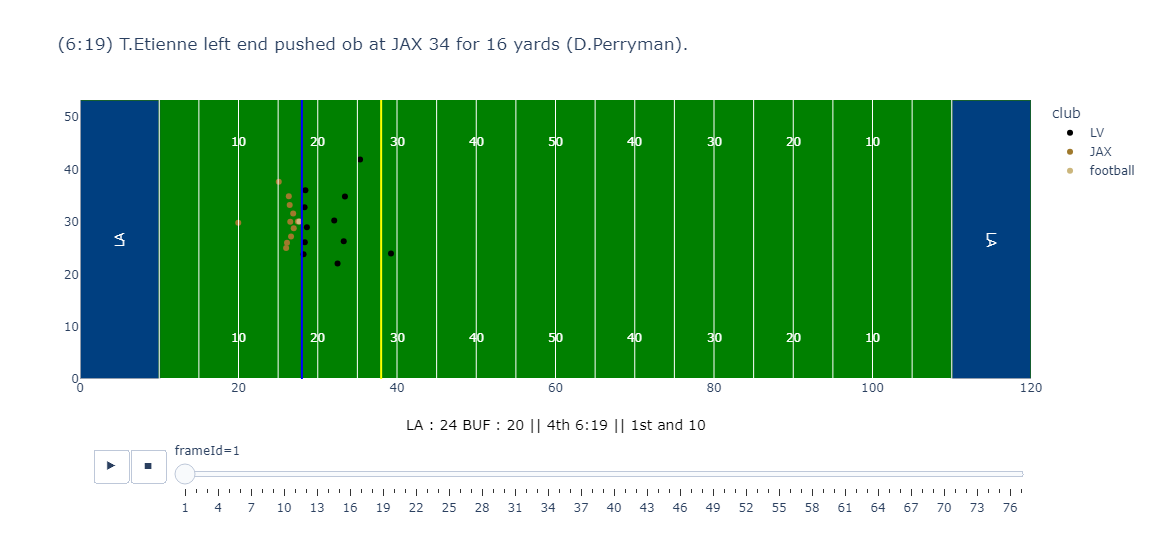


False Positives (FP) Example:
True Label: 0, Predicted Label: 1


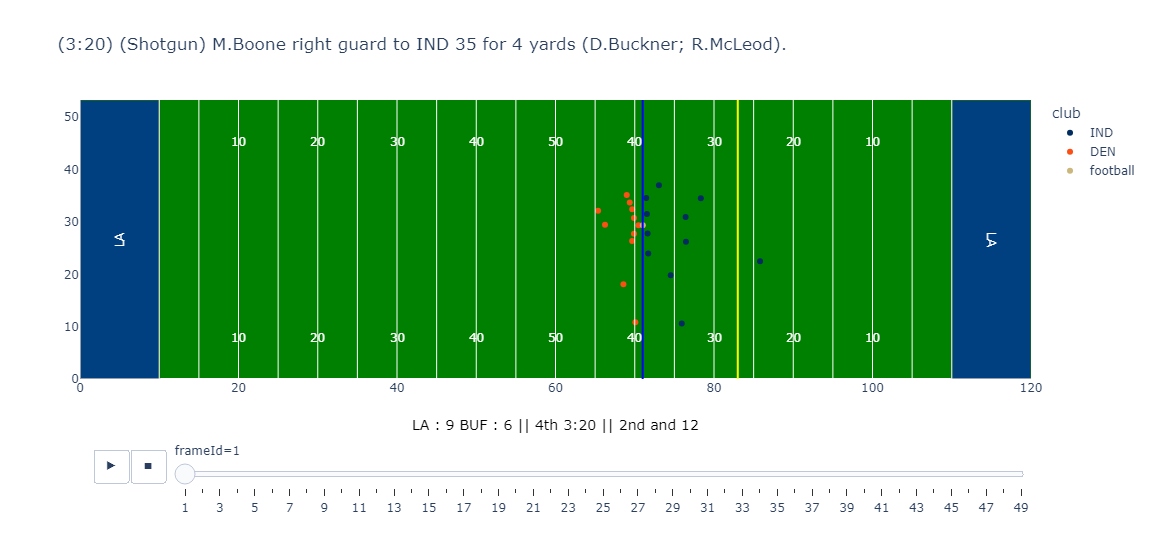


True Negatives (TN) Example:
True Label: 0, Predicted Label: 0


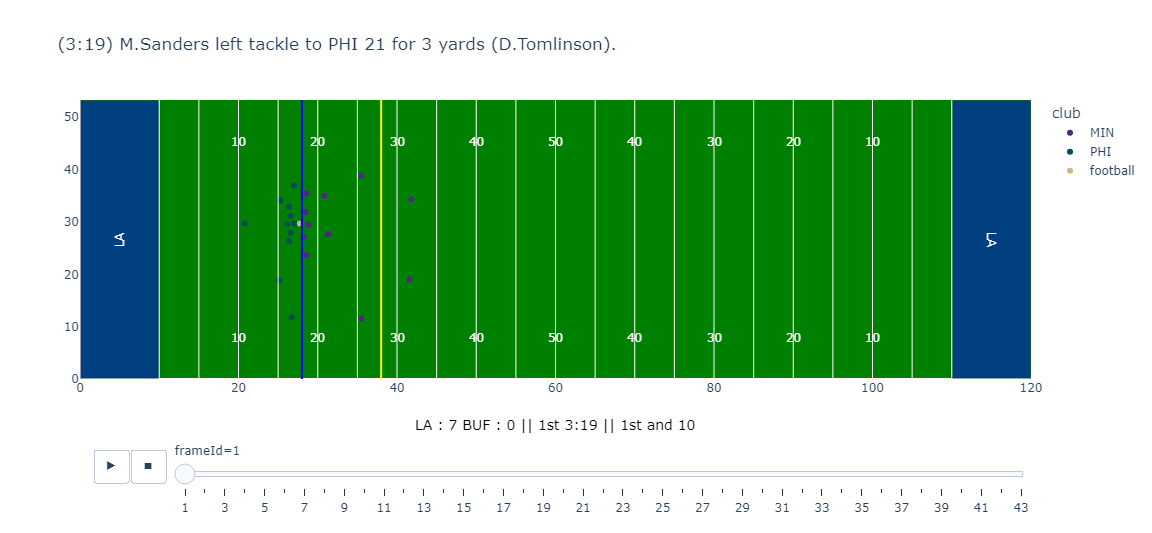


False Negatives (FN) Example:
True Label: 1, Predicted Label: 0


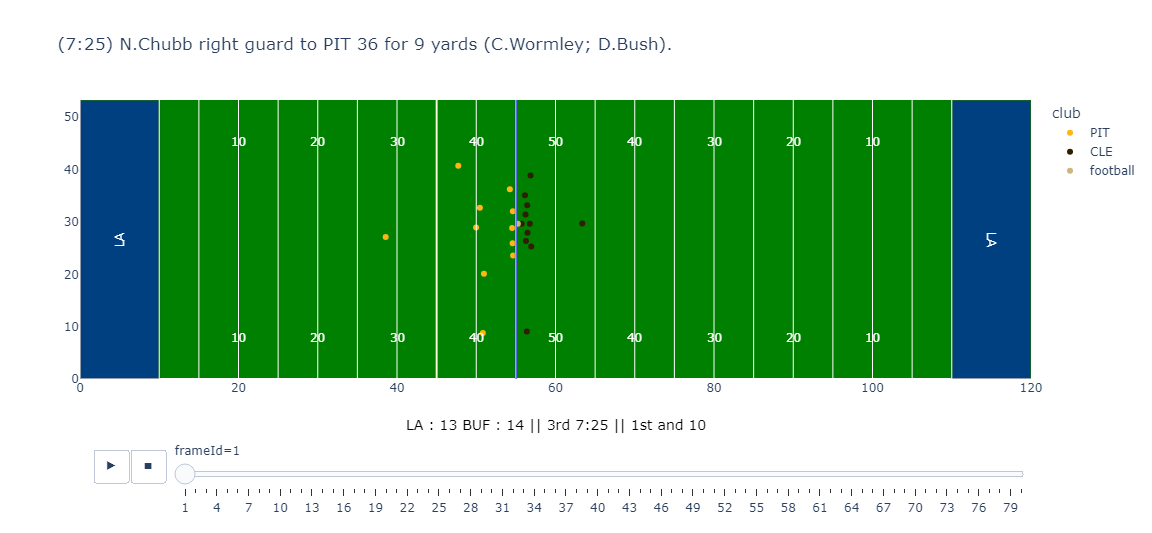

In [245]:

def plot_sample_for_category(true_label, predicted_label, category_name, week, plays, games, colors):
    indices = (y_test == true_label) & (y_pred_nn.flatten() == predicted_label)
    sample_index = X_test.index[indices][0]
    sample = yac_df.loc[sample_index]

    playId = sample['playId']
    gameId = sample['gameId']

    print(f"\n{category_name} Example:")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plot_football_play(playId, gameId, week, plays, games, colors)

# Replace gameId and playId printing with plot_football_play
plot_sample_for_category(1, 1, 'True Positives (TP)', tracking, plays, games, colors)
plot_sample_for_category(0, 1, 'False Positives (FP)', tracking, plays, games, colors)
plot_sample_for_category(0, 0, 'True Negatives (TN)', tracking, plays, games, colors)
plot_sample_for_category(1, 0, 'False Negatives (FN)', tracking, plays, games, colors)

